# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

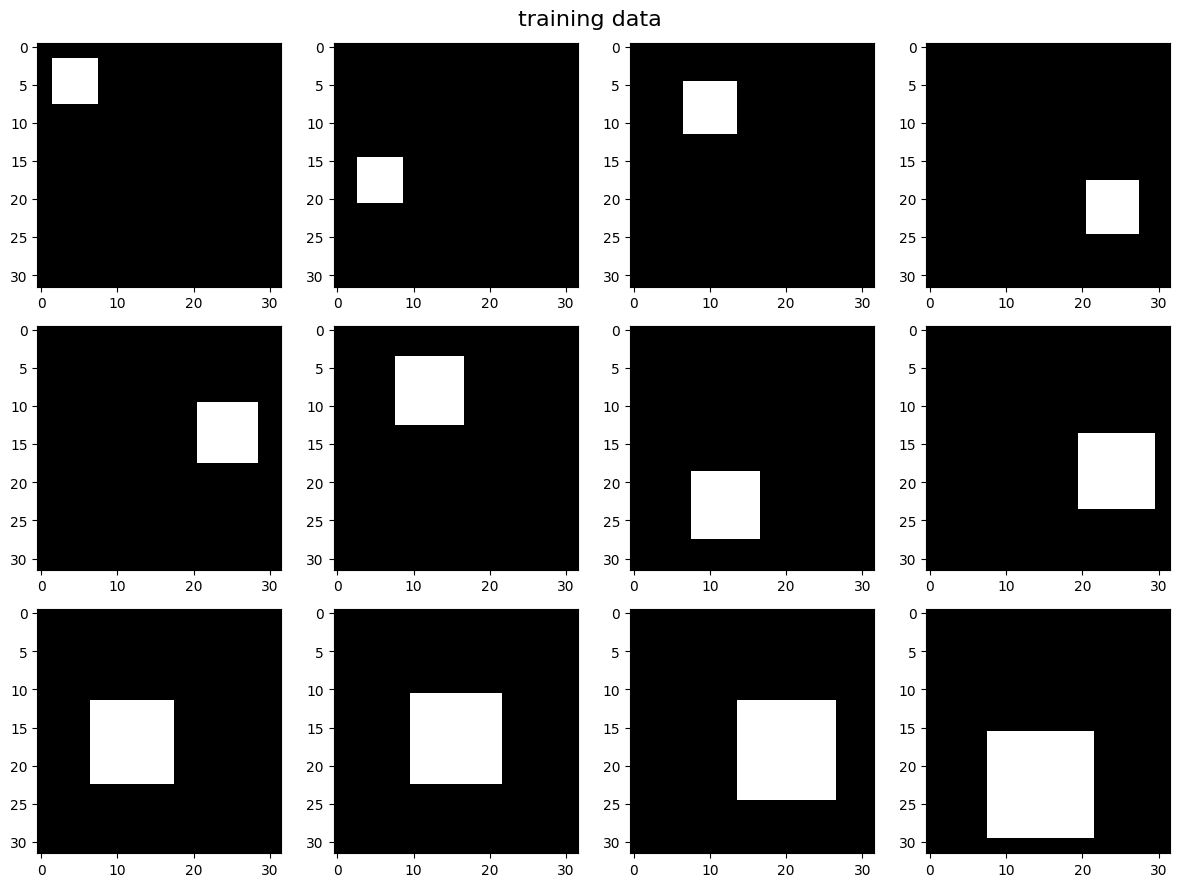

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

mps


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
#             nn.MaxPool2d((2,2)),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
#             nn.MaxPool2d((2,2)),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
#             nn.MaxPool2d((2,2)),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
#             nn.MaxPool2d((2,2)),
            
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
#             nn.MaxPool2d((2,2)),
#             nn.Tanh()
        )
        
#         self.fc = nn.Sequential(
# #             nn.Linear(in_features=256, out_features=256, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=128, out_features=64, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=64, out_features=32, bias=True),
# #             nn.LeakyReLU(0.2),
            
# #             nn.Linear(in_features=32, out_features=16, bias=True),
# #             nn.LeakyReLU(0.2),
            
#             nn.Linear(in_features=256, out_features=1, bias=True),
#         )
        
#         self.network = nn.Sequential(
#             self.conv,
#             nn.Flatten(),
            
#             self.classifier,
#         )
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.flatten(out)
#         out = self.fc(out)
        
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=dim_latent, out_channels=64, kernel_size=4, stride=1, padding=0, bias=True),
            nn.Conv2d(in_channels=dim_latent, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.LeakyReLU(0.2),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        
#         self.batch_size = x.size(0)

#         x = self.fc(x),
# #         print(x, len(x))
#         x = torch.reshape(x[0], [self.batch_size, 1, 32, 32])
        out = self.conv(x)
        
#         out = self.network(x)
        return out

## build network

In [13]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [15]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [16]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [17]:
def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_fake = compute_prediction(discriminator, fake)
#         label_fake = torch.ones_like(prediction_fake)
#         loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
        loss_generator = -torch.mean(prediction_fake)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        
        prediction_real = compute_prediction(discriminator, real)
        loss_real = -torch.mean(prediction_real)
        
        fake = compute_prediction(generator, latent)
        prediction_fake = compute_prediction(discriminator, fake.detach())
        loss_fake = torch.mean(prediction_fake)
        
        alpha = torch.randn((real.size(0), 1, 1, 1), device=device)
        interpolates = (alpha * real + ((1 - alpha) * fake)).requires_grad_(True)
        discriminator_interpolates = compute_prediction(discriminator, interpolates)
        grad_outputs = torch.ones(discriminator_interpolates.size(), device=device, requires_grad=False)
        gradients = torch.autograd.grad(
            outputs = discriminator_interpolates,
            inputs = interpolates,
            grad_outputs = grad_outputs,
            create_graph = True,
            retain_graph = True,
            only_inputs = True
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = torch.mean((gradients.norm(2, dim=1) -1) ** 2)
        
#         loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones_like(prediction_real, device=device))
#         loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros_like(prediction_fake, device=device))
#         loss_discriminator = loss_real + loss_fake

        loss_discriminator = loss_real + loss_fake + 10 * gradient_penalty
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)
        
    
# def calculate_gradient_penalty(model, real_images, fake_images):
#     """Calculates the gradient penalty loss for WGAN GP"""
#     # Random weight term for interpolation between real and fake data
#     alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
#     # Get random interpolation between real and fake data
#     interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

#     model_interpolates = model(interpolates)
#     grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

#     # Get gradient w.r.t. interpolates
#     gradients = torch.autograd.grad(
#         outputs=model_interpolates,
#         inputs=interpolates,
#         grad_outputs=grad_outputs,
#         create_graph=True,
#         retain_graph=True,
#         only_inputs=True,
#     )[0]
#     gradients = gradients.view(gradients.size(0), -1)
#     gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
#     return gradient_penalty

## test

In [18]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [19]:
number_epoch    = 100
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in range(number_epoch):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch
    print(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}, accuracy={accuracy}')

/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_723/474554764.py:7: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)


epoch 0, loss_generator = 0.4168043389640473, loss_discriminator=-0.22963535366234955, accuracy=15.343464851379395
epoch 1, loss_generator = 1.1283735928712069, loss_discriminator=-1.0246167580286663, accuracy=18.908016204833984
epoch 2, loss_generator = 1.6302741041889897, loss_discriminator=9.614681586512813, accuracy=21.189090728759766
epoch 3, loss_generator = 1.9497876714777063, loss_discriminator=31.242252109668872, accuracy=14.320609092712402
epoch 4, loss_generator = 2.200309223598904, loss_discriminator=69.32124801211887, accuracy=9.551133155822754
epoch 5, loss_generator = 2.3542576524946424, loss_discriminator=125.54993526317455, accuracy=9.300863265991211
epoch 6, loss_generator = 2.531369415918986, loss_discriminator=205.7452658759223, accuracy=10.536593437194824
epoch 7, loss_generator = 2.5746400391613995, loss_discriminator=339.2312410707827, accuracy=12.511667251586914
epoch 8, loss_generator = 2.426340894345884, loss_discriminator=488.0053167272497, accuracy=11.960571

epoch 73, loss_generator = -29.054670277348272, loss_discriminator=2361.8691232186775, accuracy=87.59273529052734
epoch 74, loss_generator = -30.15430600201642, loss_discriminator=1262.3410741735388, accuracy=87.44606018066406
epoch 75, loss_generator = -29.586587934140805, loss_discriminator=1772.278778641312, accuracy=86.56092834472656
epoch 76, loss_generator = -30.3868106842041, loss_discriminator=2028.2591093275282, accuracy=88.256103515625
epoch 77, loss_generator = -30.618699094984265, loss_discriminator=1419.1716129444264, accuracy=88.00373077392578
epoch 78, loss_generator = -31.51431087917752, loss_discriminator=1417.4641486839012, accuracy=87.14881134033203
epoch 79, loss_generator = -31.5762792940493, loss_discriminator=1742.8407366717304, accuracy=87.81831359863281
epoch 80, loss_generator = -32.56164319073712, loss_discriminator=1603.8019059357819, accuracy=86.76612091064453
epoch 81, loss_generator = -32.89211544460721, loss_discriminator=2080.365993867097, accuracy=86.9

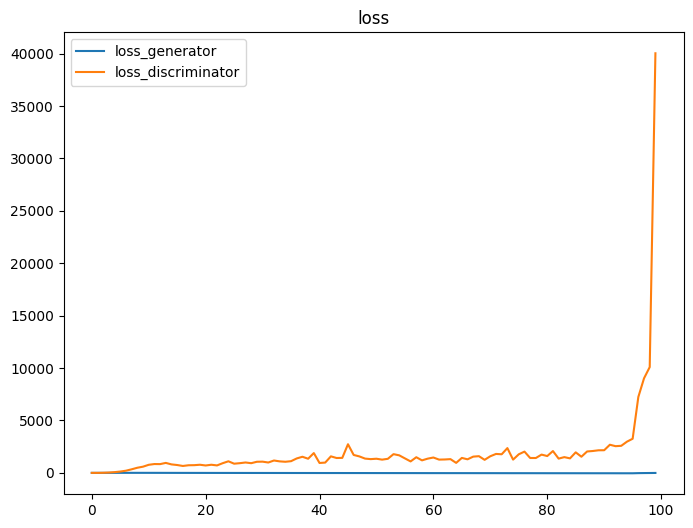

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(loss_generator, label='loss_generator')
plt.plot(loss_discriminator, label='loss_discriminator')
# plt.ylim(0,1)
plt.legend()
plt.title('loss')
plt.show()

---

# functions for presenting the results

---

In [22]:
num_latent_visualize = 16

latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

prediction = compute_prediction(generator, latent_visualize)
prediction = prediction.squeeze(axis=1)

fake = prediction.detach().cpu()

nRow = 4
nCol = 4 
size = 3 

fake.max(), fake.min(), fake.size()

# title = 'fake image'
# fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
# fig.suptitle(title, fontsize=16)

# for r in range(nRow): 
#     for c in range(nCol):
#         k = c + r * nCol
#         axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
#         axes[r, c].xaxis.set_visible(False)
#         axes[r, c].yaxis.set_visible(False)

# plt.tight_layout()
# plt.show()

(tensor(1.), tensor(1.5914e-12), torch.Size([16, 32, 32]))

In [23]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [24]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [25]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



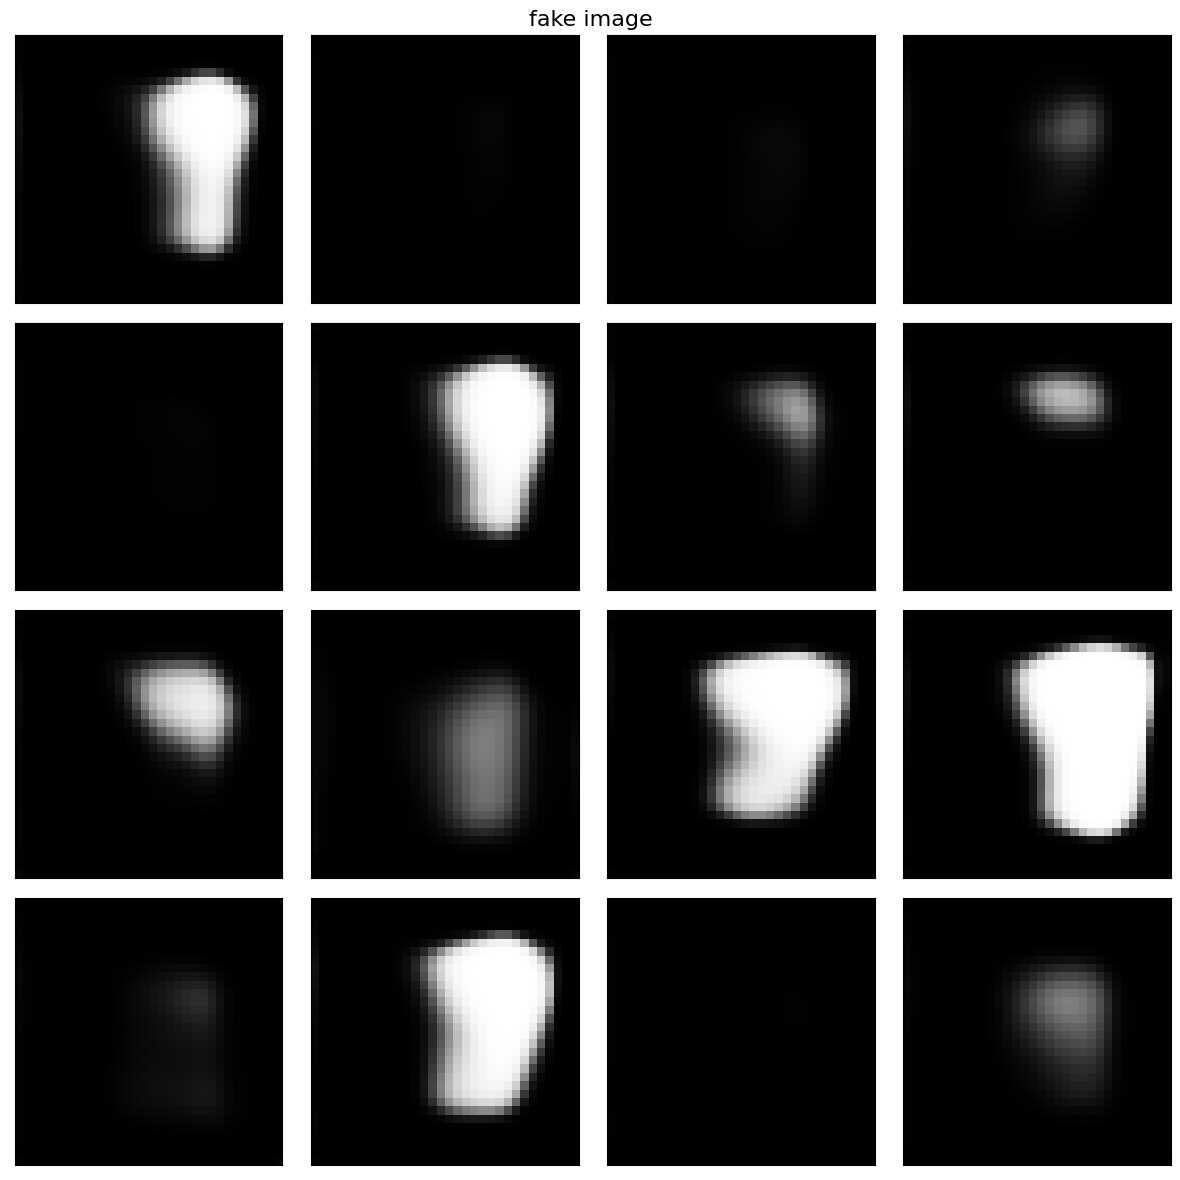

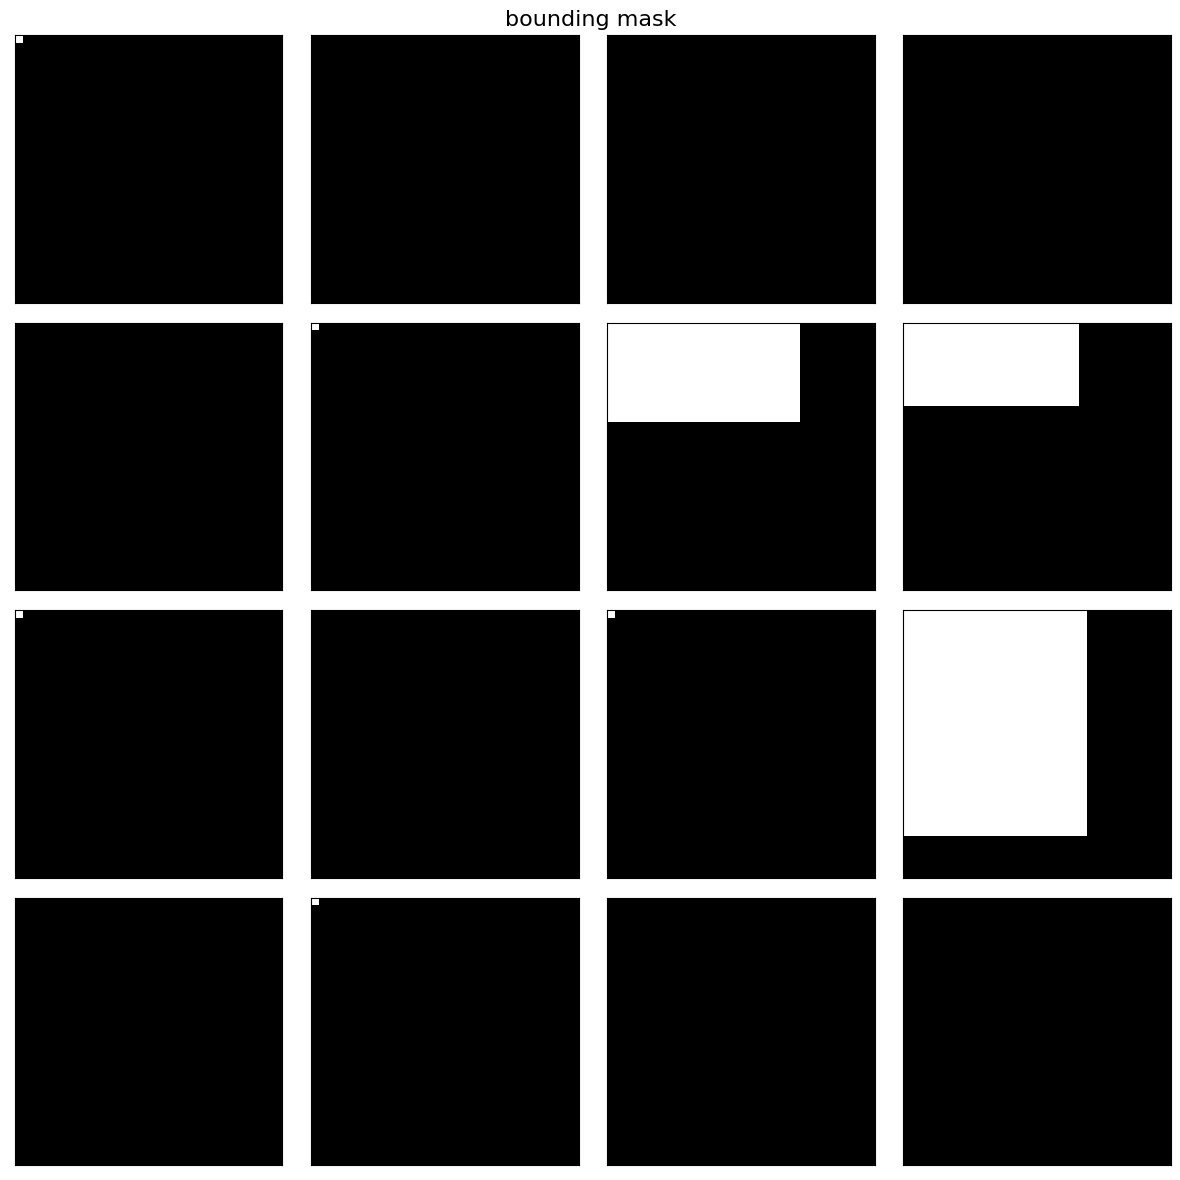


################################################################################
#
# RESULT # 02
#
################################################################################



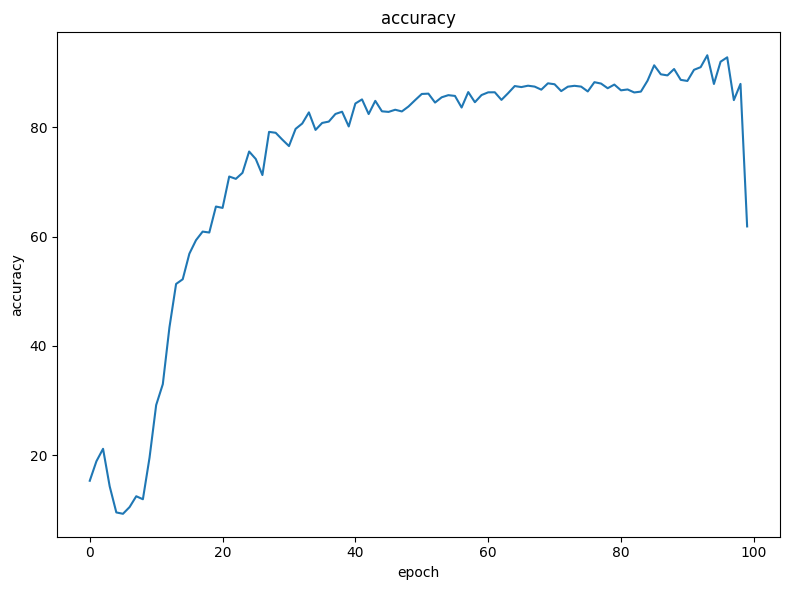


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 61.86880493


In [27]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [24]:
# https://github.com/Lornatang/WassersteinGAN_GP-PyTorch/tree/master